# 🎤 Artists Popularity
By *Artur Gomes Simão*

This notebook uses the Kaggle dataset 'Music artists popularity' (https://www.kaggle.com/datasets/pieca111/music-artists-popularity), to estimate the number of listeners of an artist, using different AI strategies and methods.

## First Steps

Importing Libraries

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

Loading the dataset

In [91]:
popularity = pd.read_csv('artist_popularity/artists.csv')
popularity.head()

C:\Users\artur\AppData\Local\Temp\ipykernel_14544\369110390.py:1: DtypeWarning: Columns (2,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  popularity = pd.read_csv('artist_popularity/artists.csv')


,mbid,artist_mb,artist_lastfm,country_mb,country_lastfm,tags_mb,tags_lastfm,listeners_lastfm,scrobbles_lastfm,ambiguous_artist
0,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,Coldplay,United Kingdom,United Kingdom,rock; pop; alternative rock; british; uk; brit...,rock; alternative; britpop; alternative rock; ...,5381567.0,360111850.0,False
1,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,Radiohead,United Kingdom,United Kingdom,rock; electronic; alternative rock; british; g...,alternative; alternative rock; rock; indie; el...,4732528.0,499548797.0,False
2,8bfac288-ccc5-448d-9573-c33ea2aa5c30,Red Hot Chili Peppers,Red Hot Chili Peppers,United States,United States,rock; alternative rock; 80s; 90s; rap; metal; ...,rock; alternative rock; alternative; Funk Rock...,4620835.0,293784041.0,False
3,73e5e69d-3554-40d8-8516-00cb38737a1c,Rihanna,Rihanna,United States,Barbados; United States,pop; dance; hip hop; reggae; contemporary r b;...,pop; rnb; female vocalists; dance; Hip-Hop; Ri...,4558193.0,199248986.0,False
4,b95ce3ff-3d05-4e87-9e01-c97b66af13d4,Eminem,Eminem,United States,United States,turkish; rap; american; hip-hop; hip hop; hiph...,rap; Hip-Hop; Eminem; hip hop; pop; american; ...,4517997.0,199507511.0,False


In [92]:
popularity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466083 entries, 0 to 1466082
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   mbid              1466083 non-null  object 
 1   artist_mb         1466070 non-null  object 
 2   artist_lastfm     986755 non-null   object 
 3   country_mb        662368 non-null   object 
 4   country_lastfm    211498 non-null   object 
 5   tags_mb           119946 non-null   object 
 6   tags_lastfm       381075 non-null   object 
 7   listeners_lastfm  986760 non-null   float64
 8   scrobbles_lastfm  986760 non-null   float64
 9   ambiguous_artist  1466083 non-null  bool   
dtypes: bool(1), float64(2), object(7)
memory usage: 102.1+ MB


Now that we know the number of data points and the types of data, we need to convert them in a way that artificial intelligence can use them.


To do this, we will transform the parameters 'ambiguous_artist' and 'country_lastfm' into floats.

In [93]:
from sklearn.preprocessing import LabelEncoder

popularity['ambiguous_artist'] = popularity['ambiguous_artist'].astype(int).astype(float)

country_map = {
    'Unknown': 0.0,
    'United States': 1.0,
    'United Kingdom': 2.0,
    'Germany': 3.0,
    'Japan': 4.0,
    'France': 5.0,
}

default_value = 0.0
popularity['country_lastfm'] = (
    popularity['country_lastfm']
    .fillna('Unknown')
    .astype(str)
    .str.strip()
    .str.title()
    .apply(lambda x: country_map.get(x, default_value))
    .astype(int)
)

The 'features' parameter will represent the main characteristics for determining the artist's number of listeners.


In [94]:
features = [
    'country_lastfm',
    'scrobbles_lastfm',
    'ambiguous_artist'
]

Additionally, there are some columns with null data. Therefore, we will ignore this missing information.


In [95]:
popularity = popularity.dropna(subset=features)

## Exploratory Analisys

In the following graphs, we can get an idea of ​​how the chosen features influence the popularity of an artist.


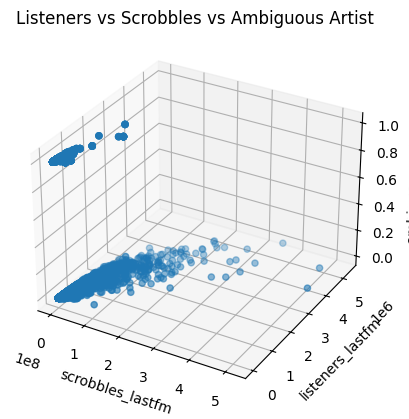

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D
ax.scatter(
    popularity['scrobbles_lastfm'], 
    popularity['listeners_lastfm'], 
    popularity['ambiguous_artist']
)

# Labels
ax.set_xlabel('scrobbles_lastfm')
ax.set_ylabel('listeners_lastfm')
ax.set_zlabel('ambiguous_artist')

plt.title('Listeners vs Scrobbles vs Ambiguous Artist')
plt.show()


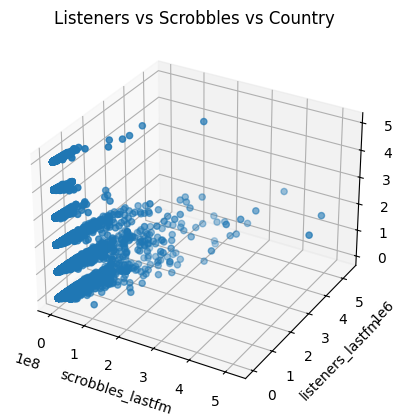

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D
ax.scatter(
    popularity['scrobbles_lastfm'], 
    popularity['listeners_lastfm'], 
    popularity['country_lastfm']
)

# Labels
ax.set_xlabel('scrobbles_lastfm')
ax.set_ylabel('listeners_lastfm')
ax.set_zlabel('country_lastfm')

plt.title('Listeners vs Scrobbles vs Country')
plt.show()

From these graphs, we can analyze that the number of listeners has a fairly linear relationship with the number of scrobbles, and the country and page sharing status on last.fm contribute somewhat to the numbers. It is also possible to notice the presence of outliers in the data.

The following histogram shows the distribution of listeners by artist.

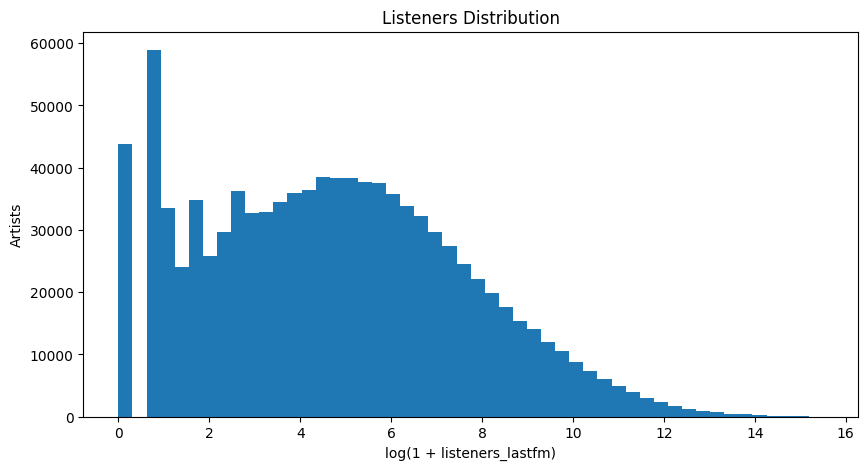

In [98]:
plt.figure(figsize=(10,5))
plt.hist(np.log1p(popularity['listeners_lastfm']), bins=50)
plt.xlabel('log(1 + listeners_lastfm)')
plt.ylabel('Artists')
plt.title('Listeners Distribution')
plt.show()

This histogram shows that the number of artists with a low number of listeners is very high, and decreases as the number of listeners increases.

## Pre-Processing

In the exploratory analysis, we can observe the presence of outliers in the data, which can hinder the training of artificial intelligence models. Therefore, corrections to the database are necessary.

Importing libraries for corrections:

In [99]:
from sklearn.model_selection import train_test_split
from scipy import stats

Another important thing to do is remove the outputs that are equal to 0, because otherwise the model metrics will have problems.


In [100]:
popularity_filtered = popularity[popularity['listeners_lastfm'] != 0].copy()

print(f"Original samples: {len(popularity)}")
print(f"Filtered samples: {len(popularity_filtered)}")

Original samples: 986760
Filtered samples: 942906


Before applying the filter, we need to define the input(x) and output(y) of the models.


In [101]:
x_val = popularity_filtered[features]
y_val = popularity_filtered['listeners_lastfm']

Now, to remove the outliers, we are going to use the IQR method:

In [102]:
Q1 = x_val.quantile(0.25)
Q3 = x_val.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = ~((x_val < lower_bound) | (x_val > upper_bound)).any(axis=1)
x_filtered = x_val[mask]
y_filtered = y_val[mask]

print(f"Number of original samples: {len(x_val)}")
print(f"Filtered samples: {len(x_filtered)}")
print(f"Samples removed: {len(x_val) - len(x_filtered)}")



Number of original samples: 942906
Filtered samples: 740605
Samples removed: 202301


Since the dataset is very large, we will also reduce the total number of samples so that the training time is shorter.

In [ ]:
temp = x_filtered.copy()
temp['listeners_lastfm'] = y_filtered

temp['listeners_log'] = np.log1p(temp['listeners_lastfm'])

N_BINS = 10
temp['popularity_bin'] = pd.cut(
    temp['listeners_log'], 
    bins=N_BINS, 
    labels=False, 
    include_lowest=True
)

samples_number = 10000
samples_per_bin = samples_number // N_BINS

x_y_sampled_stratified = (
    temp.groupby('popularity_bin')
    .sample(
        n=samples_per_bin,      
        replace=True,           
        random_state=999
    )
)

x_sampled_stratified = x_y_sampled_stratified.drop(
    columns=['listeners_lastfm', 'listeners_log', 'popularity_bin']
)
y_sampled_stratified = x_y_sampled_stratified['listeners_lastfm']

x_sampled = x_sampled_stratified.sample(frac=1, random_state=999)
y_sampled = y_sampled_stratified.loc[x_sampled.index]

In [109]:
print(f'length x_sampled: {len(x_sampled)}')
print(f'length y_sampled: {len(y_sampled)}')
print(f'length x_filtered: {len(x_filtered)}')
print(f'length y_filtered: {len(y_filtered)}')
print(f'length x_y_sampled_stratified: {len(x_y_sampled_stratified)}')

length x_sampled: 10000
length y_sampled: 10620
length x_filtered: 740605
length y_filtered: 740605
length x_y_sampled_stratified: 10000


After that, we need to split the dataset into training (80%) and testing (20%) sets:


In [104]:

x_train, x_test, y_train, y_test = train_test_split(
    x_sampled, y_sampled,
    test_size=0.2,
    random_state=999,
)

ValueError: Found input variables with inconsistent numbers of samples: [10000, 10620]

With this steps, we can begin training the models.


## Linear Regretion

Importing libraries:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

To apply the model, we need to normalize the data and then apply logistic regression. Note that the maximum number of iterations used was 5000 to allow the model time to learn, and the 'saga' parameter was used because it is efficient with large databases.
:


In [ ]:
lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

print(f'R²:{r2_score(y_test, y_pred_lr):.4f}')

R²:0.6467


This shows that R-squared using linear regression is 0.63. The next script will verify the other metrics:

In [ ]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100

print(f"MAE : {mae_lr:.4f}")
print(f"MAPE: {mape_lr:.2f}%")
print(f"MSE : {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")

MAE : 150.0119
MAPE: 436.42%
MSE : 114968.0889
RMSE: 339.0694


With these metrics (MAE = 150.23 | MAPE = 400.61% | MSE = 106560.31 | RMSE = 326.43) we can conclude that the linear regression model is not yet the most suitable for the chosen database. This happens because the chosen database is not 100% linear and contains some variations in the data.




## Decision Tree

Importing libraries:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Training model with 'squared-error' parameter and 'max_depth=10' to avoid overfitting:

In [ ]:
dt = DecisionTreeRegressor(criterion='squared_error', max_depth=5, random_state=999)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)

print(f'R²:{r2_score(y_test, y_pred_dt):.4f}')

R²:0.6500


This shows that the decision tree model has a r-squared of 0.64. Now, let's see the metrics.

In [ ]:
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mape_dt = np.mean(np.abs((y_test - y_pred_dt) / y_test)) * 100

print(f"MAE : {mae_dt:.4f}")
print(f"MAPE: {mape_dt:.2f}%")
print(f"MSE : {mse_dt:.4f}")
print(f"RMSE: {rmse_dt:.4f}")

MAE : 143.3968
MAPE: 132.44%
MSE : 113367.0571
RMSE: 336.7002


With these metrics (MAE = 145.18 | MAPE = 116.46% | MSE = 118107.64 | RMSE = 343.66), we can conclude that the decision tree model is slightly better than linear regression, with a much lower percentage of estimation error. This may have happened because the tree model is quite sensitive to noise, sometimes generating flawed generalizations.





## SVM

Importing libraries:

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Just like in the logistic regression model, we need to normalize the data before training the model. After that, during training, we use the regularization parameter 'C' as 100, improving the training:


In [82]:
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=100, gamma='scale'))
])

svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)

print(f'R²:{r2_score(y_test, y_pred_svm):.4f}')

R²:0.6284


Now for the other metrics:

In [60]:
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
mape_svm = np.mean(np.abs((y_test - y_pred_svm) / y_test)) * 100

print(f"MAE : {mae_svm:.4f}")
print(f"MAPE: {mape_svm:.2f}%")
print(f"MSE : {mse_svm:.4f}")
print(f"RMSE: {rmse_svm:.4f}")

MAE : 139.9852
MAPE: 99.41%
MSE : 119209.8865
RMSE: 345.2678


With the metrics (Precision = 0.73 | Recall = 0.74 | F1 Score = 0.73) and the confusion matrix, it is possible to state that the SVM model is much more robust than the previous ones because it is highly effective in high-dimensional spaces, which is very useful in this case.


## MLP

Importing libraries:

In [61]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

To train this model, we first normalized the data and then performed the training. In this case, we used 3 layers of neurons (300, 150, and 75 neurons) and 500 iterations.


In [89]:
mlp_model = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(300, 150), 
                        activation='relu', 
                        solver='adam', 
                        max_iter=5000, 
                        random_state=999, 
                        alpha=0.0001,
                        early_stopping=True))
])

mlp_model.fit(x_train, y_train)

y_pred_mlp = mlp_model.predict(x_test)

print(f'R²:{r2_score(y_test, y_pred_mlp):.4f}')


R²:0.6495


Checking the other metrics:

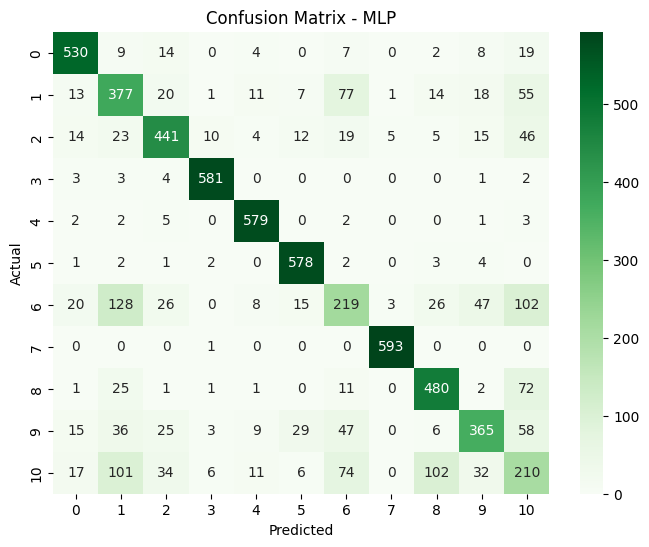


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       593
           1       0.53      0.63      0.58       594
           2       0.77      0.74      0.76       594
           3       0.96      0.98      0.97       594
           4       0.92      0.97      0.95       594
           5       0.89      0.97      0.93       593
           6       0.48      0.37      0.42       594
           7       0.99      1.00      0.99       594
           8       0.75      0.81      0.78       594
           9       0.74      0.62      0.67       593
          10       0.37      0.35      0.36       593

    accuracy                           0.76      6530
   macro avg       0.75      0.76      0.75      6530
weighted avg       0.75      0.76      0.75      6530



In [102]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))

This metrics (Precision = 0.75 | Recall = 0.76 | F1 Score = 0.75) and the confusion matrix, shows that the MLP model is the best for this classification with multiple features and achieves the goal of 75% accuracy. This is due to the model's ability to model complex non-linear relationships in the data, which is the case with this dataset. 





## Conclusions

Classifying musical genres based on basic characteristics such as popularity, tempo (bpm), and sonic characteristics (acousticness, energy, etc.) is a very complex process that requires addressing several non-linear perspectives. Therefore, based on the analysis, the MLP model performed best among the others (75,85% accuracy).



The applied preprocessing techniques were also very useful in training the models. Removing outliers and missing data helped in better generalizing the model (ignoring very specific cases). Furthermore, sample synthesis using SMOTE proved essential to improve the imbalance between classes. Although this technique, in a way, 'creates' new samples, it's important to emphasize that music is very broad and often doesn't follow a specific rule, so the most commonly used parameters in synthesis were employed, resulting in better standardization.


Moving on to an analysis of the results of the best model (MLP), a graph was plotted below showing the model's errors and successes on the test set, as well as the average confidence per class.


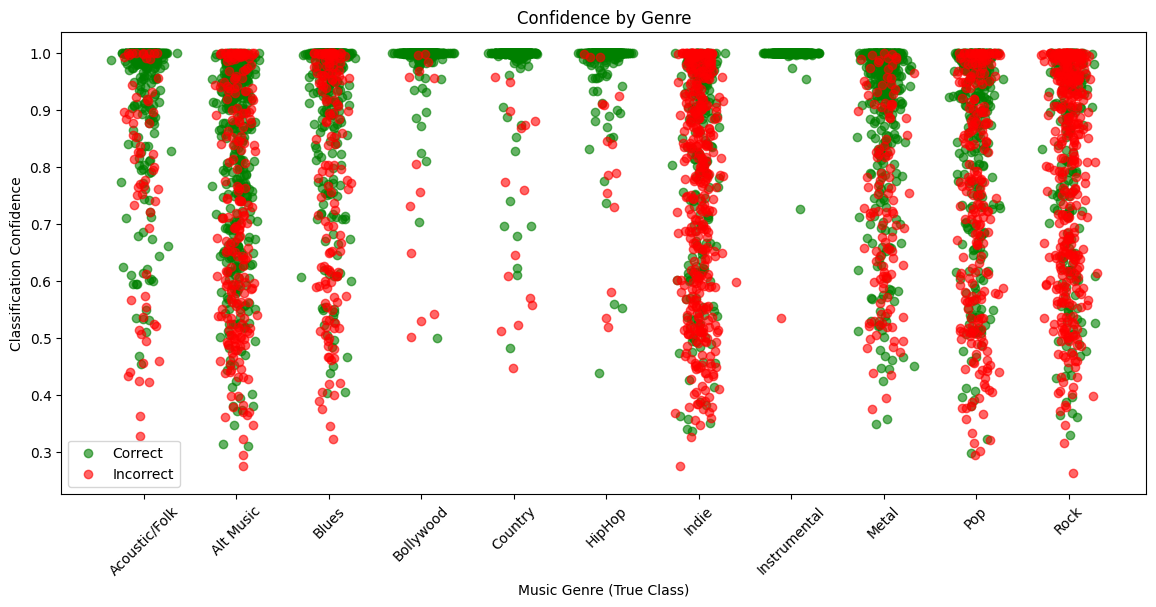


Summary of results by class:
            Corrects  Incorrects  Average_Confidence
Real Genre                                          
0                530          63            0.943143
1                377         217            0.782672
2                441         153            0.901665
3                581          13            0.991776
4                579          15            0.987053
5                578          15            0.988077
6                219         375            0.775437
7                593           1            0.998543
8                480         114            0.884952
9                365         228            0.826261
10               210         383            0.807303


In [103]:
y_pred_mlp = mlp_model.predict(x_test)
y_proba_mlp = mlp_model.predict_proba(x_test)

confidence = np.max(y_proba_mlp, axis=1)

correct = (y_pred_mlp == y_test)

df_plot = pd.DataFrame({
    'Real Genre': y_test,
    'Predicted Genre': y_pred_mlp,
    'Confidence': confidence,
    'Correct?': correct
}).reset_index(drop=True)

jitter = 0.1 * np.random.randn(len(df_plot))

plt.figure(figsize=(14, 6))

plt.scatter(
    df_plot['Real Genre'][df_plot['Correct?']] + jitter[df_plot['Correct?']],
    df_plot['Confidence'][df_plot['Correct?']],
    color='green', alpha=0.6, label='Correct'
)

plt.scatter(
    df_plot['Real Genre'][~df_plot['Correct?']] + jitter[~df_plot['Correct?']],
    df_plot['Confidence'][~df_plot['Correct?']],
    color='red', alpha=0.6, label='Incorrect'
)

plt.xlabel('Music Genre (True Class)')
plt.ylabel('Classification Confidence')
plt.title('Confidence by Genre')
plt.legend()

unique_classes = sorted(df_plot['Real Genre'].unique())
plt.xticks(
    ticks=unique_classes,
    labels=[genre_mapping[c] for c in unique_classes],
    rotation=45
)

plt.show()

summary = df_plot.groupby('Real Genre').agg(
    Corrects=('Correct?', lambda x: sum(x)),
    Incorrects=('Correct?', lambda x: len(x) - sum(x)),
    Average_Confidence=('Confidence', 'mean')
)

print("\nSummary of results by class:")
print(summary)


From this graph, we can see that the results were very good in most categories, with only a higher error rate in the Rock and Indie genres.


Interestingly, these were the classes with the highest number of initial samples, showing that the large variance in data (even after the pre-processing stage) directly influenced the model's performance. (Remember again that this variance is due to music being something very complex and subjective.)


To finish this notebook, we will add 3 songs to the dataset and see how the model classifies them.
Below are the song titles and how they are classified on the internet (The data is based on the website: https://tunebat.com/):
- Pop: Manchild - Sabrina Carpenter
- Hip-Hop: Lucid Dreams - Juice WRLD
- Indie/Alt Music: Ode to Viceroy - Mac DeMarco


In [ ]:
new_songs = pd.DataFrame([
    {
        # Manchild - Sabrina Carpenter (Pop)
        'Popularity': 86.0, 
        'danceability': 0.73,
        'energy': 0.69, 
        'liveness': 0.32, 
        'loudness': -4.500, 
        'speechiness': 0.06,
        'acousticness': 0.12, 
        'instrumentalness': 0.00, 
        'valence': 0.75, 
        'tempo': 123.0 
    },
    {
        # Lucid Dreams - Juice WRLD (Hip-Hop)
        'Popularity': 83.0,
        'danceability': 0.51,
        'energy': 0.57, 
        'liveness': 0.34,
        'loudness': -7.000,  
        'speechiness': 0.20,  
        'acousticness': 0.35, 
        'instrumentalness': 0.00,
        'valence': 0.22, 
        'tempo': 84.0  
    },
    {
        # Ode to Viceroy - Mac DeMarco (Indie/Alt Music)
        'Popularity': 62.0,
        'danceability': 0.52,
        'energy': 0.63, 
        'liveness': 0.12,
        'loudness': -6.000,  
        'speechiness': 0.05,  
        'acousticness': 0.21, 
        'instrumentalness': 0.01,
        'valence': 0.31, 
        'tempo': 95.0  
    }
], index=['Manchild', 'Lucid Dreams', 'Ode to Viceroy'])

genre_predict = mlp_model.predict(new_songs)
genre_confidence = np.max(mlp_model.predict_proba(new_songs), axis=1)

results = pd.DataFrame({
    'Song': new_songs.index,
    'Genre': genre_predict,
    'Confidence (%)': np.round(genre_confidence * 100, 2)
})

results['Genre'] = results['Genre'].map(genre_mapping)

print(results)


             Song      Genre  Confidence (%)
0        Manchild        Pop           99.99
1    Lucid Dreams     HipHop          100.00
2  Ode to Viceroy  Alt Music           52.66


Based on this final test, we can conclude that the MLP model is very good for performing classifications, especially with multiple variables (as in this case). The results were very satisfactory, and despite the musical genre theme being quite broad, the classifications with songs outside the dataset were convincing.
